In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(vegan)
library(dplyr)
library(ggplot2)
library(rwantshue)

Loading required package: permute
Loading required package: lattice
This is vegan 2.3-0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
#install.packages("dplyr")

NULL


In [4]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

physeq = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(physeq)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(physeq) = sd
sample_data(physeq)
# Cleaning up the sample data table

Sample Data:        [66 samples by 3 sample variables]:
         Cosm Month          Trtmt
B__        NA    NA          Blank
F_2_15     15   2.0   Ferrihydrite
F_2_28     28   2.0   Ferrihydrite
F_2_33     33   2.0   Ferrihydrite
F_2_9       9   2.0   Ferrihydrite
F_2.5_13   13   2.5   Ferrihydrite
F_2.5_14   14   2.5   Ferrihydrite
F_2.5_16   16   2.5   Ferrihydrite
F_2.5_27   27   2.5   Ferrihydrite
F_2.5_3     3   2.5   Ferrihydrite
F_2.5_30   30   2.5   Ferrihydrite
F_2.5_31   31   2.5   Ferrihydrite
F_2.5_42   42   2.5   Ferrihydrite
F_2.5_49   49   2.5   Ferrihydrite
F_3_12     12   3.0   Ferrihydrite
F_3_20     20   3.0   Ferrihydrite
F_3_22     22   3.0   Ferrihydrite
F_3_23     23   3.0   Ferrihydrite
F_3_44     44   3.0   Ferrihydrite
H_2.5_13   13   2.5 Heavy Fraction
H_2.5_3     3   2.5 Heavy Fraction
H_2.5_42   42   2.5 Heavy Fraction
K_2.5_13   13   2.5      Kaolinite
K_2.5_14   14   2.5      Kaolinite
K_2.5_16   16   2.5      Kaolinite
K_2.5_27   27   2.5      Kaolinite

In [5]:
%%R
md = sample_data(physeq)
# Collecting the sample data

In [6]:
%%R
otu_tab = t(otu_table(physeq)) %>% data.frame
# Making the otu table into a data frame

In [7]:
%%R
head(otu_tab)

          B__ F_2_15 F_2_28 F_2_33 F_2_9 F_2.5_13 F_2.5_14 F_2.5_16 F_2.5_27
76_110406   0      0      0      0     0        0        0        1        0
103_43      0    378    737   4570   189     2450     3784      959     1533
41_115941   0      2      0      0     0        0        0        1        2
72.2_697    0      2     11      3     2        3       27       48       17
49_12296    0      0      0      0     0        1        7        3       93
53_7       12    421    647    383    81       43      806      427      500
          F_2.5_3 F_2.5_30 F_2.5_31 F_2.5_42 F_2.5_49 F_3_12 F_3_20 F_3_22
76_110406       3        0        0        0        2      0      0      0
103_43        921      666      523      239     1156   1109   2936    700
41_115941       1        0        4        0        2      5      0      1
72.2_697      152        9       31      331       51     85     88    102
49_12296        5       10        0       16       32     64      0      2
53_7       

In [8]:
%%R
colnames(otu_tab) = colnames(t(otu_table(physeq)))
# Fixing the column names to be the proper OTUs, without X in front of them.

In [9]:
from cogent.maths.stats.rarefaction import rarefaction
import pandas.rpy.common as com
from numpy import vstack, arange, mean
import pandas as pd

/opt/virt_env/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [10]:
def get_raref_vector(data, stride=10, iters=25):
    rare_data = vstack([[len(h.nonzero()[0]) for h in rarefaction(data, stride=stride)] \
                        for i in range(iters)])
    X = arange(stride,data.sum()+stride,stride)
    return X, mean(rare_data, axis=0)

In [11]:
otu_tab = com.load_data("otu_tab")

In [12]:
%%time
# This takes a few minutes
dfs = {}
for sid in otu_tab.columns:
    counts = otu_tab[sid]
    x, raref_data = get_raref_vector(counts, iters=10)
    dfs[sid] = pd.DataFrame(data={"x" : x, "y" : raref_data})  

CPU times: user 2min 40s, sys: 413 ms, total: 2min 41s
Wall time: 3min 8s


In [13]:
d = pd.concat(dfs, axis=0)
d.reset_index(inplace=True)
d.drop(["level_1"], axis=1, inplace=True)
d.rename(columns={"level_0" : "SampleID"}, inplace=True)
d.head()

,SampleID,x,y
0,B__,10,9.8
1,B__,20,18.0
2,B__,30,25.8
3,B__,40,32.1
4,B__,50,39.2


In [14]:
d = com.convert_to_r_dataframe(d, strings_as_factors=True)
%Rpush d

In [15]:
%%R
d<-data.frame(d)

In [16]:
%%R
head(d)

  SampleID  x    y
0      B__ 10  9.8
1      B__ 20 18.0
2      B__ 30 25.8
3      B__ 40 32.1
4      B__ 50 39.2
5      B__ 60 44.7


In [17]:
%%R
md = sample_data(physeq) %>% data.frame %>% add_rownames("SampleID")

In [18]:
%%R
head(d)

  SampleID  x    y
0      B__ 10  9.8
1      B__ 20 18.0
2      B__ 30 25.8
3      B__ 40 32.1
4      B__ 50 39.2
5      B__ 60 44.7


In [19]:
%%R

d.plot = d %>% 
    left_join(md)
head(d.plot)

Joining by: "SampleID"
  SampleID  x    y Cosm Month Trtmt
1      B__ 10  9.8   NA    NA Blank
2      B__ 20 18.0   NA    NA Blank
3      B__ 30 25.8   NA    NA Blank
4      B__ 40 32.1   NA    NA Blank
5      B__ 50 39.2   NA    NA Blank
6      B__ 60 44.7   NA    NA Blank


Joining by: "SampleID"


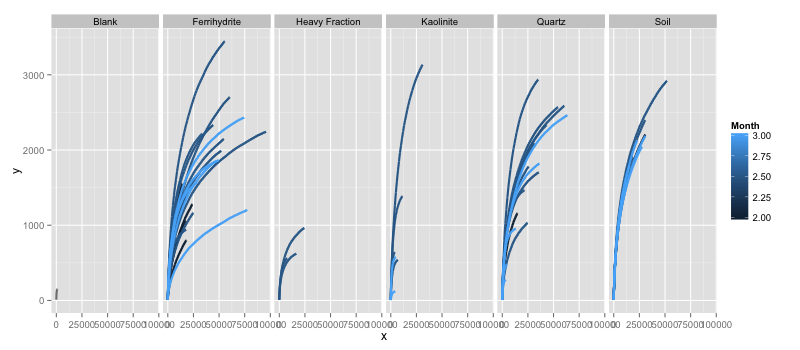

In [20]:
%%R -w 800 -h 350

d.plot = d %>% 
    left_join(md)

p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Month))

p = p + facet_grid(. ~ Trtmt)

p = p + geom_line(size = 1)

p   

Joining by: "SampleID"


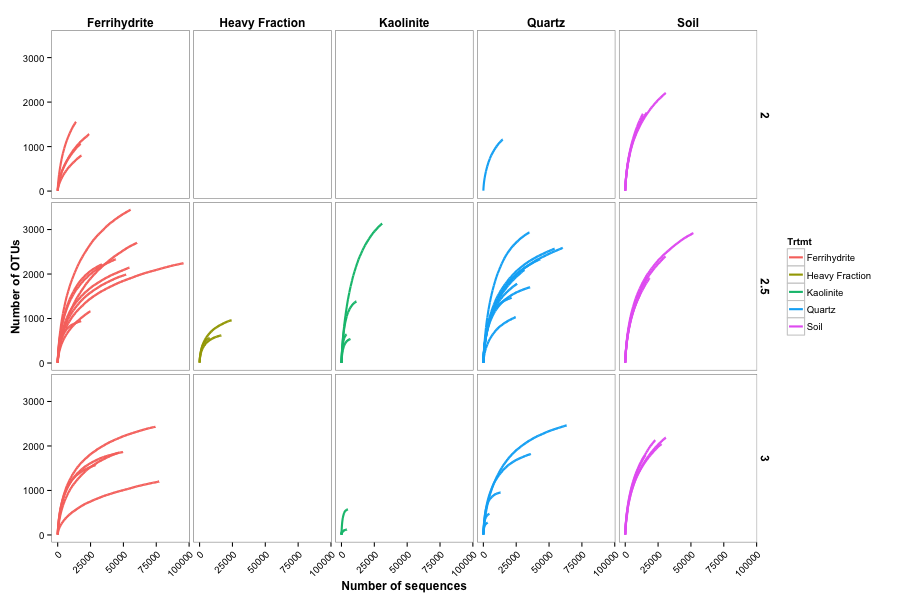

In [21]:
%%R -w 900 -h 600

d.plot = d %>% 
    left_join(md)

d.plot = d.plot %>%
    filter(Trtmt!="Blank")

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Trtmt)), color_space = hcl_presets$pastel)


p = ggplot(d.plot, aes(x = x, y = y, group = SampleID, color = Trtmt))

p = p + facet_grid(Month ~ Trtmt)

p = p + geom_line(size = 1)

#p = p + labs(colour = "Substrate")

p = p + ylab("Number of OTUs") + xlab("Number of sequences") 
#+ xlim(0,10000)
#+ xlim(0,2000) + ylim(0,1000)

p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  )

p = p + scale_fill_manual(values = colors)

p = p + theme(axis.text.x=element_text(angle = 45, hjust = 1))

p = p + theme(axis.title.x = element_text(size=12, face="bold")
             ,axis.title.y = element_text(size=12, face="bold"))

p = p + theme(strip.text = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))

p = p + theme(strip.text.x = element_text(size=12, face="bold"),
        strip.background = element_rect(colour="white", fill="white"))

p   